In [1]:
# neccessities for the project setup
# this enables automatic reload of the libraries specific to this project
%load_ext autoreload
%autoreload 1

import os
import sys

# fs_utils.py stores paths to every other directory in the projects
# this module is located at the top level of the repository
# jupyter can't see it unless I change the cwd manually
# official man page tells that it's not actually possible in any other way
sys.path.append(os.path.abspath(".."))
%aimport fs_utils

# extend != append, the former appends the content while 
# the latter — the list with two elements...
os.chdir(fs_utils.ROOT_DIR)
sys.path.extend([fs_utils.LIB_DIR, fs_utils.ROOT_DIR, fs_utils.SRC_DIR])

In [2]:
# standard library
import gc
import pickle
gc.enable()

In [30]:
# third-party modules
from collections import defaultdict
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import scipy.stats as sps
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook

%matplotlib inline

In [4]:
# custom modules
%aimport util
%aimport qtls

In [5]:
expression_df, genotypes_df, qtls_df = {}, {}, {}

expression_df["eQTLs_2018"] = pd.read_table("./data/raw/eQTLs/2018/expression.csv")
genotypes_df["eQTLs_2018"] = pd.read_table("./data/raw/eQTLs/2018/genotypes_filtered.csv")

qtls_df["eQTLs_2018"] = pd.read_table("./data/processed/eQTLs/2018/qtls_albert&bloom_from_paper.csv")
qtls_df["eQTLs_2018"].rename({"LOD" : "score"}, axis=1, inplace=True)
qtls_df["eQTLs_2018"]["score"] = MinMaxScaler().fit_transform(
    qtls_df["eQTLs_2018"]["score"].values[:,None]
)
qtls_df["eQTLs_2018"]["score"] = 1 - qtls_df["eQTLs_2018"]["score"]

# Physical and genetic interactions taken from TheBioGrid project
full_interactome_df = pd.read_table("./data/raw/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[
#     full_interactome_df['Publication year'] <= 2011]

genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association", "colocalization", "direct interaction",
    "physical association"
]

In [6]:
interaction_categories = physical_interaction_categories
interactome_df = full_interactome_df.copy()
interactome_df.set_index('Interaction Type', inplace=True)

# genetic_interactions_df = interactome_df[interactome_df.index.isin(
#     genetic_interaction_categories)]
physical_interactions_df = interactome_df[interactome_df.index.isin(
    physical_interaction_categories)]


def extract_interactions(interactions_df):
    ''' Helper function to retrieve the edges of the graph of interactions '''
    return interactions_df[["Interactor A", "Interactor B"]].values

interactome_graphs_dict = {}
for category_name in ["physical"]:
    with open("./data/raw/interactions/{}_interactions_graph.pkl".format(category_name), "rb") as pickle_file:
        interactome_graphs_dict[category_name] = pickle.load(pickle_file)
interactome_graph = interactome_graphs_dict["physical"]

**Introduction — interacting vs. random:**  
*“Physically interacting genes share more linkages than expected at random”*  

- For each edge, compute the Jaccard coefficient of the sets of markers linked to its endpoints. 
- Then generate the same number of random gene pairs, compute the coefficients. 
- Repeat a few thousand times and average the results. 

Compare distributions of Jaccard coefficients through such statistics, as:

- p-value from MWU test
- mean coefficient
- confidence interval 

A function generating this figure must reside in `qtls` module and be well-documented. 
Let's call it `random_pairs_test`.

In [71]:
class RandomPairsTest:
    def __init__(self, interactome, qtls_df, score_thresholds, max_iter):
        self.interactome = interactome
        assert "score" in qtls_df.columns, "provided QTLs don't have associated scores"
        assert np.all((0 <= qtls_df["score"]) & (qtls_df["score"] <= 1)),\
                "scores must be scaled to fit into (0, 1)"
        self.qtls_df = qtls_df
        assert np.all((0 <= score_thresholds) & (score_thresholds <= 1)),\
                "some thresholds are outside (0, 1)"
        self.score_thresholds = score_thresholds
        self.max_iter = max_iter
        
        self.n_edges = interactome.ecount()
        self.n_nodes = interactome.vcount()
        self.node_names = interactome.vs["name"]

        self.edges = [
            (node_names[e.source], node_names[e.target])
            for e in interactome_graph.es
        ]
    
    @staticmethod
    def jaccard_from_edge(edge, linked_markers):
        source, target = edge
        if not linked_markers[source].size and not linked_markers[target].size:
            return -1 
        return qtls.jaccard(set(linked_markers[source]), 
                            set(linked_markers[target]))

    @staticmethod
    def process_edges(edges_list, node_names, qtls_df, score_thresholds):
        results = []
        for thresh in score_thresholds:
            signif_qtls_df = qtls_df[qtls_df["score"] <= thresh]
            linked_markers = {v : qtls.linked_markers(signif_qtls_df, v)
                              for v in node_names}

            jaccard = np.fromiter((jaccard_from_edge(edge, linked_markers)
                                   for edge in edges_list), dtype=np.float32)

            linksim = jaccard[jaccard >= 0]
            results.append([
                np.mean(linksim),
                np.count_nonzero(jaccard == -1)
            ])

            del jaccard, linked_markers, signif_qtls_df
        return np.ravel(np.vstack(results)[:, 0])

    def map(self):
        self.simulation_results = defaultdict(list)
        self.simulation_results["actual"] = process_edges(self.edges, 
                                                          self.node_names, 
                                                          self.qtls_df, 
                                                          self.score_thresholds)
        self.simulation_results["random"] = np.column_stack(
            Parallel(n_jobs=10)(
                delayed(process_edges)(
                    [(self.node_names[u], self.node_names[v]) 
                     for u, v in util.sample_combinations((n_nodes, n_nodes), n_edges)], 
                    self.node_names, 
                    self.qtls_df, 
                    self.score_thresholds
                ) for _ in range(self.max_iter)
            ))
        
    def reduce(self, summarize=True):
        if summarize:
            simulation_summary = {
                "1st-quartile" : np.quantile(self.simulation_results["random"], 0.25, axis=1),
                "median" : np.median(self.simulation_results["random"], axis=1),
                "3rd-quartile" : np.quantile(self.simulation_results["random"], 0.75, axis=1)
            }
            return {"actual" : self.simulation_results["actual"], 
                    "random" : simulation_summary}
        return self.simulation_results
    
    def map_reduce(self, summarize=True):
        self.map()
        return self.reduce(summarize)

In [72]:
rptest = RandomPairsTest(interactome_graph, 
                         qtls_df["eQTLs_2018"],
                         np.linspace(0.8, 1, 10),
                         10)
simulation_results = rptest.map_reduce()

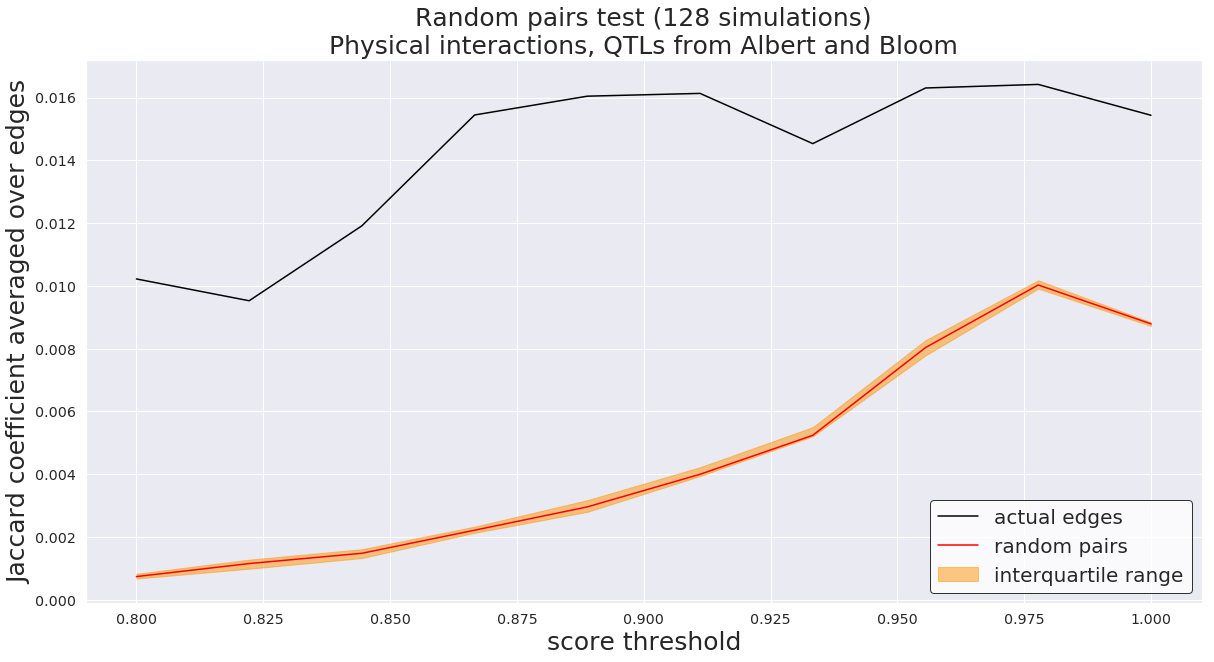

In [74]:
sns.set(font_scale=1.3)
plt.figure(figsize=(20,10))
plt.title("Random pairs test (128 simulations)\nPhysical interactions, QTLs from Albert and Bloom", fontsize=25)
plt.xlabel("score threshold", fontsize=25)
plt.ylabel("Jaccard coefficient averaged over edges", fontsize=25)
plt.plot(score_thresholds, 
         simulation_results["actual"], 
         label="actual edges", 
         c="black")
# simulation_summary = {
#     "1st-quartile" : np.quantile(simulation_results["random"], 0.25, axis=1),
#     "median" : np.median(simulation_results["random"], axis=1),
#     "3rd-quartile" : np.quantile(simulation_results["random"], 0.75, axis=1)
# }
plt.plot(score_thresholds, 
         simulation_summary["median"], 
         label="random pairs", 
         c="red")
plt.fill_between(score_thresholds, 
                 simulation_summary["1st-quartile"],  
                 simulation_summary["3rd-quartile"], 
                 color="xkcd:tangerine", alpha=0.5, 
                 label="interquartile range")
legend = plt.legend(loc="lower right", fontsize=20);
frame = legend.get_frame();
frame.set_facecolor("white");
frame.set_edgecolor("black");